# Git Repository Bringup

In [2]:
!git version

git version 2.34.1


In [5]:
!git clone https://github.com/ramwtz/data-science-project.git

Cloning into 'data-science-project'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 36 (delta 13), reused 29 (delta 8), pack-reused 0
Receiving objects: 100% (36/36), 3.53 MiB | 9.58 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [6]:
!ls

data-science-project  drive  sample_data


In [9]:
%cd data-science-project/

/content/data-science-project


In [10]:
!pwd

/content/data-science-project


In [11]:
!git switch dev/ram

Branch 'dev/ram' set up to track remote branch 'dev/ram' from 'origin'.
Switched to a new branch 'dev/ram'


In [ ]:
!git config --global user.email “ramwtz@gmail.com”

!git config --global user.name “ramwtz”

# Basic Bringup for Remote Envrionment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Necessary packages for this nb
!pip install torch openai-whisper pandas SpeechRecognition vosk librosa ipython-autotime tqdm tensorflow seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 794.3/794.3 kB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 127.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20230918-py3-none-any.whl size=798399 sha256=fcb182ff0f39b4df77add7ff3c676d9fe72a5276c36fad911aee72784964d13b
  Stored in directory: /root/.cache/pip/wheels/5d/37/b1/9aea93201fe91e3561719120da92cc23e77b7ef6f3d0d9491a
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=

# Initialize Env

In [ ]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa as lbrs
import IPython
import IPython.display as ipd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn import metrics

# Configs
%load_ext autotime
tqdm.pandas()

time: 822 µs (started: 2023-09-19 14:33:18 +00:00)


In [ ]:
gen_data_dir = os.path.join('drive', 'MyDrive', 'project', 'data')
calls_dir = os.path.join(gen_data_dir, 'calls')
new_data_dir = os.path.join(gen_data_dir, 'new')

#
metadata_path = os.path.join(calls_dir, '911_first6sec', '911_metadata_6sec.csv')

time: 833 µs (started: 2023-09-19 14:33:18 +00:00)


In [ ]:
def get_path_from_filename(audio_file_name):
    type_dir, file_name = audio_file_name.split('/')
    return os.path.join(calls_dir, type_dir, file_name)

time: 447 µs (started: 2023-09-19 14:33:18 +00:00)


In [ ]:
def create_audio_series(audio_file_name):
    audio_file_path = get_path_from_filename(audio_file_name)
    data, sample_rate = lbrs.load(audio_file_path)
    return audio_file_name, data, sample_rate

time: 445 µs (started: 2023-09-19 14:33:18 +00:00)


In [ ]:
def mfcc_feature_extractor(filename):
  _, data, sr = create_audio_series(filename)
  mfcc = lbrs.feature.mfcc(
      y=data, sr=sr, n_mfcc=40)
  return np.mean(mfcc.T, axis=0)

time: 512 µs (started: 2023-09-19 14:33:18 +00:00)


# EDA

In [ ]:
# load metadata from csv to a pandas dataframe
metadata_df = pd.read_csv(metadata_path)

time: 5.6 s (started: 2023-09-19 14:33:33 +00:00)


In [ ]:
metadata_df.count()

id                 710
event_id           710
link               710
title              710
date               689
state              702
deaths             709
potential_death    709
false_alarm        709
description        701
deaths_binary      710
break              710
filename           710
dtype: int64

time: 14.9 ms (started: 2023-09-19 14:33:39 +00:00)


In [ ]:
# TODO (ram): need to find the duplicates
metadata_df.drop_duplicates(subset=['filename'], inplace=True)
metadata_df.reset_index(drop=True, inplace=True)
metadata_df.count()

id                 707
event_id           707
link               707
title              707
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      707
break              707
filename           707
dtype: int64

time: 12.7 ms (started: 2023-09-19 14:33:39 +00:00)


In [ ]:
metadata_df[metadata_df['deaths'].isnull()]

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
39,39,54,https://web.archive.org/web/20150417085342/htt...,Boat rescue #1 – Minn.,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,911_first6sec/call_54_0.wav


time: 11.2 ms (started: 2023-09-19 14:33:39 +00:00)


In [ ]:
# TODO (Ram): maybe we can tag this ourselves
metadata_df = metadata_df[metadata_df['deaths'].notna()]
metadata_df.reset_index(drop=True, inplace=True)
metadata_df.count()

id                 706
event_id           706
link               706
title              706
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      706
break              706
filename           706
dtype: int64

time: 6.85 ms (started: 2023-09-19 14:33:39 +00:00)


### Let us look into the basic elements of audio processing:
---
1. Frequency:
  - Describes the rate of oscillation (vibration).
  - Denoted in Hz (1/sec).
  - Is understood by the human ear as 'pitch'.
  - The human ear is considered to be able to hear within the range of 20 Hz to 20,000 Hz.
  
  <img src="https://uploads-cdn.omnicalculator.com/images/britannica-wave-frequency.jpg" width="500"/>
2. Intensity:
  - Proportional to the **square of the amplitude** of the audio wave [[1]](http://theory.physics.ubc.ca/341-current/dB.pdf).
  - Denoted in dB, with a pre-defined base 0dB, as it is a comapritive logarithmic scale.
  - Is understood by the human ear as 'loudness'
  
  <img src="https://theproaudiofiles.com/wp-content/uploads/2018/06/decibel-chart.png" width="500"/>
3. The relationship between Frequency and Intensity:
  
  <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124722804500162-f13-15-9780124722804.gif" width="500"/>

3. Sample Rate:
  - The rate at which we sample discrete audio signals, the standard of audio sampling is 44.1 kHz ([for historic reasons](https://www.cardinalpeak.com/blog/why-do-cds-use-a-sampling-rate-of-44-1-khz)), that is 44,100 samples per second.

  <img src="https://cdn.shopify.com/s/files/1/0970/0050/files/Sample_Rate.png?1870870584085320152" width="600"/>
  

### Now lets look over a sample audio file and see how we can observe these features:

First we can sample an audio file to listen too, so we can compare the data to actual human comprehendible sound:

In [ ]:
# sample a single audio file
sample = metadata_df.sample(1)
sample_filename = sample['filename'].iat[0]
sample_path = get_path_from_filename(sample_filename)

# Create playable audio
IPython.display.display(ipd.Audio(sample_path))

time: 389 ms (started: 2023-09-19 16:04:18 +00:00)


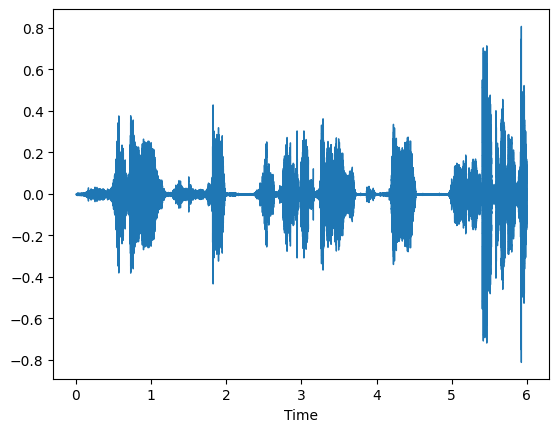

time: 698 ms (started: 2023-09-19 16:06:53 +00:00)


In [ ]:
# Get digital signal data
data, sample_rate = lbrs.load(sample_path)

# Plot waveform
lbrs.display.waveshow(data, sr=sample_rate)
plt.show()

We can see the values of the amplitude in the y-axis and the passage of time in the x-axis, lets zoom in:

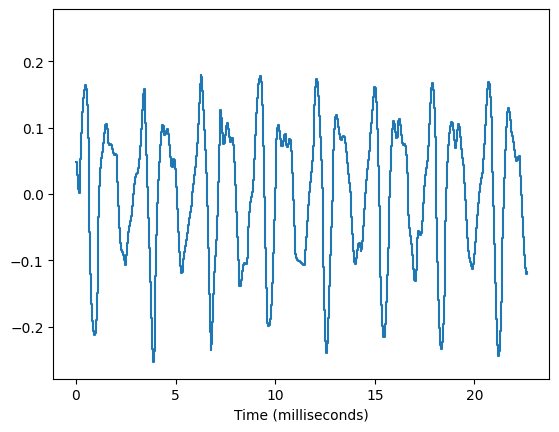

time: 278 ms (started: 2023-09-19 16:10:55 +00:00)


In [ ]:
lbrs.display.waveshow(data[20000:20500], sr=sample_rate, axis='ms')
plt.show()

This is just a fraction of the sound, and we can much more easily see that this is wave made of samples by the jaged edges.


### Visualizing frquency and intensity: The Spectogram


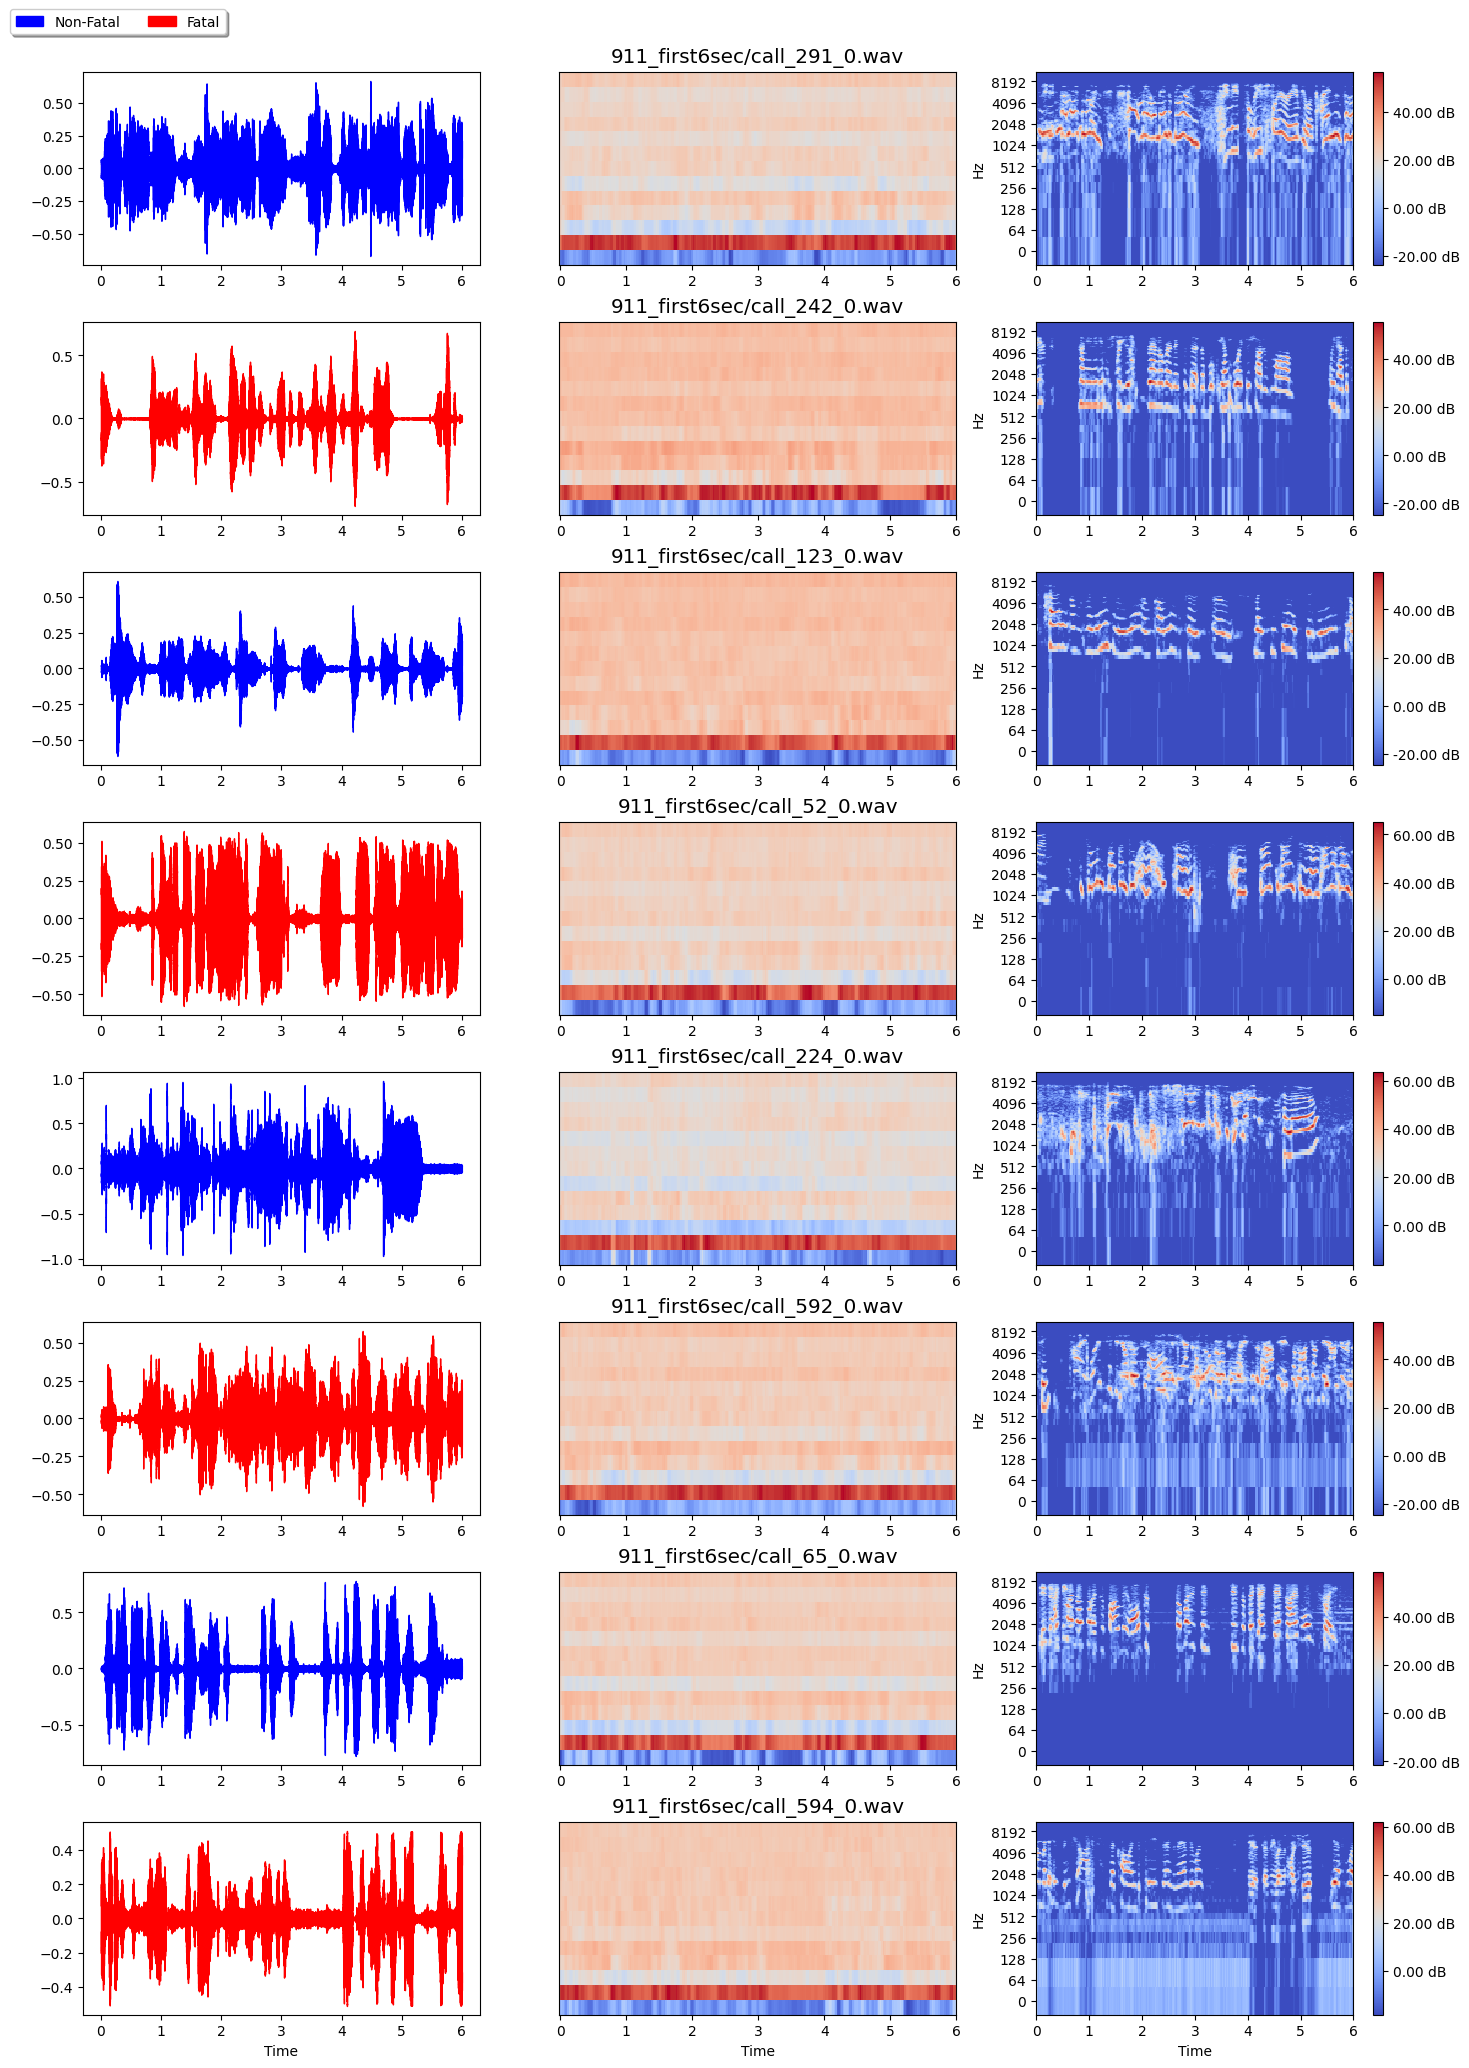

time: 15.4 s (started: 2023-09-19 16:43:36 +00:00)


In [ ]:
# params
num_rows = 8

# create base figure
fig = plt.figure(figsize=(15, 20))
subfigs = fig.subfigures(nrows=num_rows, ncols=1)

# add legend
red_patch = mpatches.Patch(color='red', label='Fatal')
blue_patch = mpatches.Patch(color='blue', label='Non-Fatal')
lgnd = [blue_patch, red_patch]
loc = (0.1, 1.02)
fig.legend(handles=lgnd, bbox_to_anchor=loc, ncol=2, fancybox=True, shadow=True)

# populate subfigures
for i, subfig in enumerate(subfigs):
  # create subplots in subfigure
  sub_axs = subfig.subplots(nrows=1, ncols=3, squeeze=True)
  subfig.subplots_adjust(left=0)

  # choose between fatal and non fatal
  cls = i % 2
  color = 'r' if cls else 'b'

  # create wave plot
  sample = metadata_df[metadata_df['deaths_binary'] == cls].sample(1)
  sample_filename = sample['filename'].iat[0]
  title, y, sr = create_audio_series(sample_filename)
  lbrs.display.waveshow(y=y, sr=sr, ax=sub_axs[0], color=color)

  # add title to subfigure
  subfig.suptitle(title, x=0.45, fontsize='x-large')

  #
  mfcc=lbrs.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  lbrs.display.specshow(mfcc, x_axis='time', ax=sub_axs[1])

  #
  S = lbrs.feature.melspectrogram(y=y, sr=sr, n_mels=128)
  db = lbrs.amplitude_to_db(S)
  img = lbrs.display.specshow(db, x_axis='time', y_axis='log', ax=sub_axs[2])
  subfig.colorbar(img, ax=sub_axs[2], format=f'%0.2f dB')

plt.show()

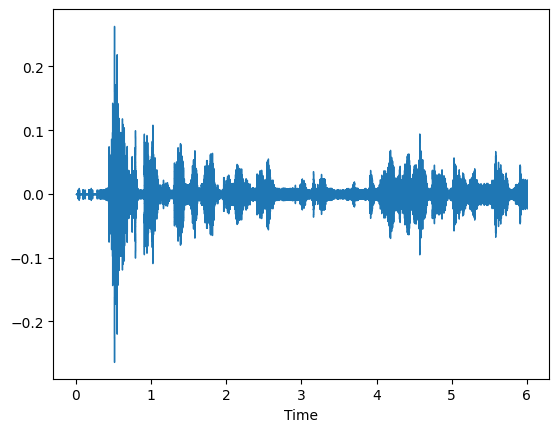

time: 649 ms (started: 2023-09-19 14:35:29 +00:00)


In [ ]:
# sample = metadata_df.sample(1)
# sample_filename = sample['filename'].iat[0]
# sample_path = get_path_from_filename(sample_filename)
# IPython.display.display(ipd.Audio(sample_path))




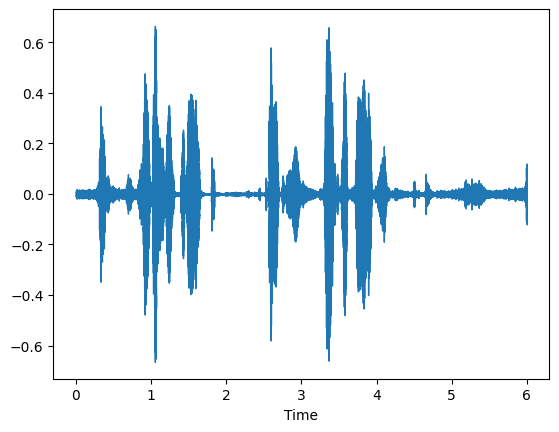

time: 343 ms (started: 2023-09-19 14:34:09 +00:00)


In [ ]:
_, data, sr = create_audio_series(sample_filename)
lbrs.display.waveshow(data, sr=sr)

# Model Train 1

 ## Initial parsing

In [ ]:
# create an audio data frame from the basic 6sec audio files
t = metadata_df['filename'].progress_apply(create_audio_series)
audio_bd_df = pd.DataFrame(
    [[a, b, c] for a, b, c in t.values],
    columns=['name', 'audio_data', 'sample_rate'])

# save to csv in new data directory
audio_bd_df.to_csv(
    os.path.join(
      new_data_dir, 'audio_break_down.csv'), encoding='utf-8', index=False)

# show
audio_bd_df

100%|██████████| 706/706 [00:08<00:00, 82.27it/s]


,name,audio_data,sample_rate
0,911_first6sec/call_2_0.wav,"[-0.0056829993, -0.007308025, -0.0068500396, -...",22050
1,911_first6sec/call_8_0.wav,"[-0.0020084537, -0.0026947297, -0.0024773255, ...",22050
2,911_first6sec/call_9_0.wav,"[-0.0009541708, -0.0021004737, -0.001991515, -...",22050
3,911_first6sec/call_10_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
4,911_first6sec/call_11_0.wav,"[-0.06825948, -0.07650047, -0.062488325, -0.06...",22050
...,...,...,...
701,911_first6sec/call_739_0.wav,"[-0.008401807, -0.010041229, -0.0072896704, -0...",22050
702,911_first6sec/call_740_0.wav,"[-0.00022829707, -0.00021101035, -0.0001955997...",22050
703,911_first6sec/call_741_0.wav,"[0.00047217117, 0.000747274, 0.00065874535, 0....",22050
704,911_first6sec/call_742_0.wav,"[0.062244687, 0.055715486, 0.012667503, -0.025...",22050


time: 8.74 s (started: 2023-09-16 12:26:58 +00:00)


In [ ]:
# Create classification
classes_df = metadata_df[['filename', 'deaths_binary']]

classes_df.rename(
  columns={'deaths_binary': 'resulted_in_deaths', 'filename': 'name'},
  inplace=True)

# save to csv in new data directory
classes_df.to_csv(
    os.path.join(
        new_data_dir, 'classes.csv'), encoding='utf-8', index=False)

# show
classes_df

<ipython-input-26-e0a5f9e06da4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_df.rename(


,name,resulted_in_deaths
0,911_first6sec/call_2_0.wav,1
1,911_first6sec/call_8_0.wav,1
2,911_first6sec/call_9_0.wav,0
3,911_first6sec/call_10_0.wav,1
4,911_first6sec/call_11_0.wav,0
...,...,...
701,911_first6sec/call_739_0.wav,0
702,911_first6sec/call_740_0.wav,0
703,911_first6sec/call_741_0.wav,1
704,911_first6sec/call_742_0.wav,1


time: 23.6 ms (started: 2023-09-16 12:27:33 +00:00)


## Extract Features

In [ ]:
# paths
classes_path = os.path.join(new_data_dir, 'classes.csv')

classes_df = pd.read_csv(classes_path)
classes_df['mfcc'] = classes_df['name'].progress_apply(mfcc_feature_extractor)

100%|██████████| 706/706 [00:30<00:00, 23.17it/s]

time: 30.5 s (started: 2023-09-12 11:32:32 +00:00)


In [ ]:
classes_df

,name,resulted_in_deaths,mfcc
0,911_first6sec/call_2_0.wav,1,"[-347.91898, 141.35872, -42.301647, -4.1033554..."
1,911_first6sec/call_8_0.wav,1,"[-397.9957, 121.41592, -61.829327, -17.909689,..."
2,911_first6sec/call_9_0.wav,0,"[-332.94348, 149.08382, -60.553104, -40.287895..."
3,911_first6sec/call_10_0.wav,1,"[-305.83057, 105.52086, 1.4551153, -6.3349667,..."
4,911_first6sec/call_11_0.wav,0,"[-266.61017, 198.4966, -87.43249, -37.422276, ..."
...,...,...,...
701,911_first6sec/call_739_0.wav,0,"[-334.4198, 136.65033, -58.533295, -3.2142577,..."
702,911_first6sec/call_740_0.wav,0,"[-269.3363, 156.94151, -52.327385, 0.3746821, ..."
703,911_first6sec/call_741_0.wav,1,"[-271.39484, 164.72687, -55.83731, -9.952957, ..."
704,911_first6sec/call_742_0.wav,1,"[-279.49335, 200.93382, -42.38867, -20.385248,..."


time: 22.5 ms (started: 2023-09-12 11:33:04 +00:00)


In [ ]:
features = np.array(classes_df['mfcc'].tolist())
classes = np.array(classes_df['resulted_in_deaths'].tolist())

time: 1.78 ms (started: 2023-09-12 11:33:09 +00:00)


In [ ]:
print(features.shape)

(706, 40)
time: 3.25 ms (started: 2023-09-12 11:00:06 +00:00)


## Train

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(
    features, classes ,test_size=0.2, shuffle=True, stratify=classes,
    # random_state=1
    )

time: 3.27 ms (started: 2023-09-12 11:33:33 +00:00)


In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(40,)))


model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
# model.add(Activation('sigmoid'))

time: 222 ms (started: 2023-09-16 15:34:29 +00:00)


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],optimizer='adam')

time: 23.3 ms (started: 2023-09-12 12:23:14 +00:00)


In [ ]:
num_epochs = 50
# num_batch_size = 32

checkpointer = ModelCheckpoint(
    filepath='saved_models/audio_classification.hdf5',
    verbose=1, save_best_only=True)

model.fit(
    X_train, y_train,
    # batch_size=num_batch_size,
    epochs=num_epochs, validation_data=(X_test, y_test),
    callbacks=[checkpointer], verbose=1)

Epoch 1/50
 1/18 [>.............................] - ETA: 16s - loss: 0.7029 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 0.67626, saving model to saved_models/audio_classification.hdf5
18/18 [==============================] - 1s 10ms/step - loss: 0.6813 - accuracy: 0.5940 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 2/50
 1/18 [>.............................] - ETA: 0s - loss: 0.6805 - accuracy: 0.5938
Epoch 2: val_loss improved from 0.67626 to 0.67611, saving model to saved_models/audio_classification.hdf5
18/18 [==============================] - 0s 7ms/step - loss: 0.6807 - accuracy: 0.5869 - val_loss: 0.6761 - val_accuracy: 0.5915
Epoch 3/50
 1/18 [>.............................] - ETA: 0s - loss: 0.6947 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/18 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.5974
Epoch 3: val_loss improved from 0.67611 to 0.67580, saving model to saved_models/audio_classification.hdf5
18/18 [==============================] - 0s 8ms/step - loss: 0.6768 - accuracy: 0.5975 - val_loss: 0.6758 - val_accuracy: 0.5915
Epoch 4/50
 1/18 [>.............................] - ETA: 0s - loss: 0.6614 - accuracy: 0.6250
Epoch 4: val_loss improved from 0.67580 to 0.67572, saving model to saved_models/audio_classification.hdf5
18/18 [==============================] - 0s 7ms/step - loss: 0.6865 - accuracy: 0.5816 - val_loss: 0.6757 - val_accuracy: 0.5915
Epoch 5/50
18/18 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.5904
Epoch 5: val_loss did not improve from 0.67572
18/18 [==============================] - 0s 6ms/step - loss: 0.6793 - accuracy: 0.5904 - val_loss: 0.6758 - val_accuracy: 0.5915
Epoch 6/50
17/18 [===========================>..] - ETA: 0s - loss: 0.6833 - accu

time: 11.3 s (started: 2023-09-12 12:32:46 +00:00)


In [ ]:
test_accuracy = model.evaluate(X_test, y_test,
  # batch_size=num_batch_size,
  verbose=0)
print(test_accuracy)

[0.6724180579185486, 0.591549277305603]
time: 96.4 ms (started: 2023-09-12 12:33:00 +00:00)


In [ ]:
y_probs = model.predict(X_test)
print(y_probs)

5/5 [==============================] - 0s 4ms/step
[[0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.41655654 0.5834434 ]
 [0.40759477 0.5924052 ]
 [0.41655654 0.5834434 ]

In [ ]:
y_predicted = np.argmax(y_probs, axis=-1)
print(y_predicted)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
time: 1.41 ms (started: 2023-09-12 12:33:13 +00:00)


In [ ]:
# notice the y_test and not cat
print(metrics.classification_report(y_test, y_predicted, digits=4, target_names=['no-death','death']))

              precision    recall  f1-score   support

    no-death     0.0000    0.0000    0.0000        58
       death     0.5915    1.0000    0.7434        84

    accuracy                         0.5915       142
   macro avg     0.2958    0.5000    0.3717       142
weighted avg     0.3499    0.5915    0.4397       142

time: 40 ms (started: 2023-09-12 12:18:06 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Train 2

 ## Initial parsing

To Address the abject failure of the first training attempt, let us even out the number of classes

In [ ]:
classes_df = pd.read_csv(
    os.path.join(new_data_dir, 'classes.csv'))

time: 1.06 s (started: 2023-09-17 11:09:47 +00:00)


In [ ]:
print(classes_df['resulted_in_deaths'].value_counts())

1    418
0    288
Name: resulted_in_deaths, dtype: int64
time: 15.5 ms (started: 2023-09-17 11:09:48 +00:00)


In [ ]:
# Create classification
num_of_non_death = classes_df['resulted_in_deaths'].value_counts()[0]
t = classes_df[classes_df['resulted_in_deaths'] == 1].sample(num_of_non_death)
classes_even_df = pd.concat(
    [t, classes_df[classes_df['resulted_in_deaths'] == 0]])

time: 7.69 ms (started: 2023-09-17 11:09:48 +00:00)


## Extract Features

In [ ]:
classes_even_df['mfcc'] = classes_even_df['name'].progress_apply(mfcc_feature_extractor)

100%|██████████| 576/576 [04:52<00:00,  1.97it/s]

time: 4min 52s (started: 2023-09-17 11:09:48 +00:00)


In [ ]:
features = np.array(classes_even_df['mfcc'].tolist())
classes = np.array(classes_even_df['resulted_in_deaths'].tolist())

time: 1.69 ms (started: 2023-09-17 11:14:40 +00:00)


In [ ]:
print(features.shape)

(576, 40)
time: 4.24 ms (started: 2023-09-17 11:14:40 +00:00)


## Train - Defs

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features, classes ,test_size=0.33, shuffle=True, stratify=classes,
    random_state=0
    )

time: 8.01 ms (started: 2023-09-17 11:14:40 +00:00)


In [ ]:
earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=50, restore_best_weights=True,
    verbose=1)

time: 628 µs (started: 2023-09-17 11:14:40 +00:00)


In [ ]:
checkpointer = callbacks.ModelCheckpoint(
    filepath='saved_models/audio_classification.hdf5',
    verbose=1, save_best_only=True)

time: 2.18 ms (started: 2023-09-17 11:14:40 +00:00)


In [ ]:
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.01, patience=1, min_lr=0.001)

## Train

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(features.shape[1],)))
# model.add(layers.Dense(units=10, activation='relu'))
# model.add(layers.Dense(units=12, activation='relu'))
# model.add(layers.Dense(units=12, activation='relu'))
model.add(layers.Dense(units=2, activation='softmax'))

time: 21.2 ms (started: 2023-09-17 17:26:38 +00:00)


In [ ]:
optimizer_name = 'RMSprop'
lr = 10 ** -6

model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=optimizers.RMSprop(lr))

time: 11 ms (started: 2023-09-17 17:26:38 +00:00)


In [ ]:
epochs = 10 ** 6

train_res  = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[
        # checkpointer,
        # earlystopping,
        # reduce_lr_callback
        ],
    verbose=0
    )
print()

KeyboardInterrupt: ignored

time: 57min 9s (started: 2023-09-17 17:26:38 +00:00)


In [ ]:
cnn_feats_history_pd = pd.DataFrame(train_res.history)
title = f'{epochs} Epochs \ {optimizer_name} \ {lr:.10f}'
cnn_feats_history_pd[['loss','val_loss']].plot(title=title,xlabel='steps', ylabel='loss')
plt.show()

In [ ]:
title = f'{epochs} Epochs \ {optimizer_name} \ {lr:.10f}'
cnn_feats_history_pd[['accuracy','val_accuracy']].plot(title=title,xlabel='steps', ylabel='accuracy')
plt.show()

In [ ]:
test_accuracy = model.evaluate(X_test, y_test,
  # batch_size=num_batch_size,
  verbose=0)
print(test_accuracy)

In [ ]:
y_probs = model.predict(X_test)

In [ ]:
y_predicted = np.argmax(y_probs, axis=-1)
print(y_predicted)

In [ ]:
# notice the y_test and not cat
print(metrics.classification_report(y_test, y_predicted, digits=4, target_names=['no-death','death']))

This is much better! Altough we have a worse score it is much more indicative of reality as in the last model we had only 1s.

In [ ]:
deep_feats_cm = metrics.confusion_matrix(y_test, y_predicted)

In [ ]:
ax = sns.heatmap(deep_feats_cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='g')

ax.set_xlabel("\nPredicted Label")
ax.set_ylabel("True Label\n")

ax.xaxis.set_ticklabels(['Non-Fatal','Fatal'])
ax.yaxis.set_ticklabels(['Non-Fatal','Fatal'])


ax.set_title("Confusion matrix for deep features neural network\n")

plt.show()

sensitivity1 = deep_feats_cm[0,0]/(deep_feats_cm[0,0]+deep_feats_cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = deep_feats_cm[1,1]/(deep_feats_cm[1,0]+deep_feats_cm[1,1])
print('Specificity : ', specificity1)